In [ ]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.compiler import transpile
from qiskit.circuit.library import QFTGate
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from fractions import Fraction
from collections import Counter
from math import gcd
from functools import reduce
import pandas as pd

In [ ]:
# --- Funciones de curva elíptica ---
def inv_mod(k, p):
    return pow(k, -1, p)

def add_points(P, Q, A):
    if P is None:
        return Q
    if Q is None:
        return P

    x1, y1 = P
    x2, y2 = Q

    if x1 == x2 and y1 != y2:
        return None

    if P == Q:
        if x1 == 0:
            return None
        m = (3 * x1 * x1 + A) * inv_mod(2 * y1, p)
    else:
        if x1 == x2:
            return None
        m = (y2 - y1) * inv_mod(x2 - x1, p)

    m %= p
    x3 = (m * m - x1 - x2) % p
    y3 = (m * (x1 - x3) - y1) % p

    return (x3, y3)

def scalar_mult(k, P, A):
    R = None
    for i in range(k):
        R = add_points(R, P, A)
    return R

def counts_to_df(counts: dict,
                 shots: int | None = None,
                 sort_by: str = "count",   # "count" | "prob" | "bitstring" | "int"
                 descending: bool = True,
                 top: int | None = None,
                 bit_order: str = "msb"    # "msb" = el bit más significativo a la izquierda (Qiskit por defecto)
                ) -> pd.DataFrame:

    if not isinstance(counts, dict) or len(counts) == 0:
        raise ValueError("counts debe ser un dict no vacío, p. ej. result.get_counts(circuit).")

    # Total de tiros (shots)
    if shots is None:
        shots = int(sum(counts.values()))

    # Construir DataFrame
    rows = []
    for bstr, c in counts.items():
        # Limpieza de posibles espacios
        b = str(bstr).replace(" ", "")
        # Interpretación como entero (base 2)
        try:
            intval = int(b, 2)
        except ValueError:
            # Si el bitstring tiene separadores (p.ej. Qiskit antiguo con espacios), ya hicimos replace arriba.
            intval = None

        prob = c / shots if shots > 0 else 0.0
        rows.append({
            "bitstring": b,
            "int": intval,
            "count": int(c),
            "prob": prob,
            "percent": prob * 100.0,
        })

    df = pd.DataFrame(rows)

    # Ordenamiento
    valid_sort_cols = {"count", "prob", "bitstring", "int"}
    if sort_by not in valid_sort_cols:
        raise ValueError(f"sort_by debe ser uno de {valid_sort_cols}")
    df = df.sort_values(by=sort_by, ascending=not descending, kind="mergesort").reset_index(drop=True)

    # Limitar a Top-k si se pide
    if top is not None and isinstance(top, int) and top > 0:
        df = df.head(top).copy()


    df["prob"] = df["prob"].map(lambda x: float(f"{x:.6f}"))
    df["percent"] = df["percent"].map(lambda x: float(f"{x:.4f}"))
    return df



def main():

    # --- Parámetros ---
  n_input = 4  # log2(N)
  N = 2 ** n_input
  shots = 2048

  # --- Parámetros de la curva elíptica ---
  p = 29
  A = 0
  B = 7
  P = (6, 7)  # punto base
  es_par = False
  # --- Tabla de puntos y codificación ---
  lista_puntos = []
  R = None

  print(f"\n📌 Curva generada: y² = x³ + {A}x + {B} mod {p}")
  print(f"🔸 Punto generador G = {P}")

  for k in range(1, p**2 + 2):
      R = add_points(R, P, A)
      if R is None or R in lista_puntos:
        if es_par	:
          lista_puntos.append((0,0))
        break
      lista_puntos.append(R)
  orden = len(lista_puntos)

  # Extensión de la secuencia periódica hasta N
  lista_extendida = [lista_puntos[i % orden] for i in range(N)]

  # Diccionario punto -> índice
  punto_a_indice = {str(pt): i for i, pt in enumerate(lista_puntos)}

  # Construcción de tabla
  rows = []
  for k in range(N):
      bin_k = format(k, f"0{N.bit_length()-1}b")   # binario con ceros a la izquierda
      punto = lista_extendida[k]                  # kP
      idx = punto_a_indice[str(punto)]            # índice asociado
      bin_idx = format(idx, f"0{orden.bit_length()}b")  # salida en binario

      rows.append({
          "k": k,
          "bin_k (entrada)": bin_k,
          "kP (punto)": str(punto),
          "bin_idx (salida)": bin_idx,
          # Puedes añadir "Puertas aplicadas" si lo defines
      })

  df = pd.DataFrame(rows)
  print("\n")
  print("Tabla de connfiguración del oráculo")
  print(df)



  # --- Circuito cuántico ---
  n_output = orden.bit_length()
  qc = QuantumCircuit(n_input + n_output, n_input)

  # 1. Superposición en registro de entrada
  qc.h(range(n_input))

  # 2. Codificación reversible k·P en segundo registro
  for k in range(N):
      bin_k = format(k, f"0{n_input}b")
      kP = lista_extendida[k]
      if kP is None:
          continue
      idx = punto_a_indice.get(str(kP), None)
      if idx is None:
          continue
      bin_idx = format(idx, f"0{n_output}b")

      for i in range(n_input):
          if bin_k[i] == '0':
              qc.x(i)
      for j in range(n_output):
          if bin_idx[j] == '1':
              qc.mcx(list(range(n_input)), n_input + j)
      for i in range(n_input):
          if bin_k[i] == '0':
              qc.x(i)

  # 3. QFT inversa sobre registro de entrada
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))

  # 4. Medición
  qc.measure(range(n_input), range(n_input))


  # --- Simulación ---
  simulator = Aer.get_backend('aer_simulator')
  qc = transpile(qc, simulator)
  result = simulator.run(qc, shots=shots).result()
  counts = result.get_counts()


  tabla = counts_to_df(counts, sort_by="count", descending=True)
  print("\n")
  print("Tabla de resultados cuánticos")
  print(tabla)

  # --- Análisis de resultados ---
  def mcm_lista(lista):
      def mcm(a, b):
          return abs(a * b) // gcd(a, b)
      return reduce(mcm, lista) if lista else None

  fracciones_info = []
  for bitstring, freq in counts.items():
      s = int(bitstring.replace(" ", ""), 2)
      if s == 0:
          continue
      frac = Fraction(s, N).limit_denominator(N)
      fracciones_info.append({
          "Medición binaria": bitstring,
          "Decimal": s,
          "Frecuencia": freq,
          "Fracción m/N": f"{s}/{N}",
          "Fracción reducida": f"{frac.numerator}/{frac.denominator}",
          "Posible orden (denominador)": frac.denominator
      })

  if fracciones_info:
      df = pd.DataFrame(fracciones_info)
      df = df.sort_values("Frecuencia", ascending=False)
      denominadores = [f["Posible orden (denominador)"] for f in fracciones_info if 1 < f["Posible orden (denominador)"] <= N]
      orden_estimado = mcm_lista(denominadores)
      input = n_input**2
      if not es_par:
        orden_estimado += 1
        input += 1
      print("\n")
      print("Tabla de fracciones continuas")
      print(df.to_string(index=False))
      if orden_estimado == input:
        print ("No se encontró un orden")
        return 0
      print("\n")
      print(f"\n🔎 Orden estimado del punto P: {orden_estimado}")
  else:
      print("⚠️ No se obtuvieron resultados útiles.")
  print("\n")
  return qc


qc = main()


📌 Curva generada: y² = x³ + 0x + 7 mod 29
🔸 Punto generador G = (6, 7)


Tabla de connfiguración del oráculo
     k bin_k (entrada) kP (punto) bin_idx (salida)
0    0            0000     (6, 7)              000
1    1            0001   (12, 13)              001
2    2            0010   (12, 16)              010
3    3            0011    (6, 22)              011
4    4            0100     (6, 7)              000
5    5            0101   (12, 13)              001
6    6            0110   (12, 16)              010
7    7            0111    (6, 22)              011
8    8            1000     (6, 7)              000
9    9            1001   (12, 13)              001
10  10            1010   (12, 16)              010
11  11            1011    (6, 22)              011
12  12            1100     (6, 7)              000
13  13            1101   (12, 13)              001
14  14            1110   (12, 16)              010
15  15            1111    (6, 22)              011


Tabla de resultados c

/tmp/ipython-input-3712161603.py:180: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))


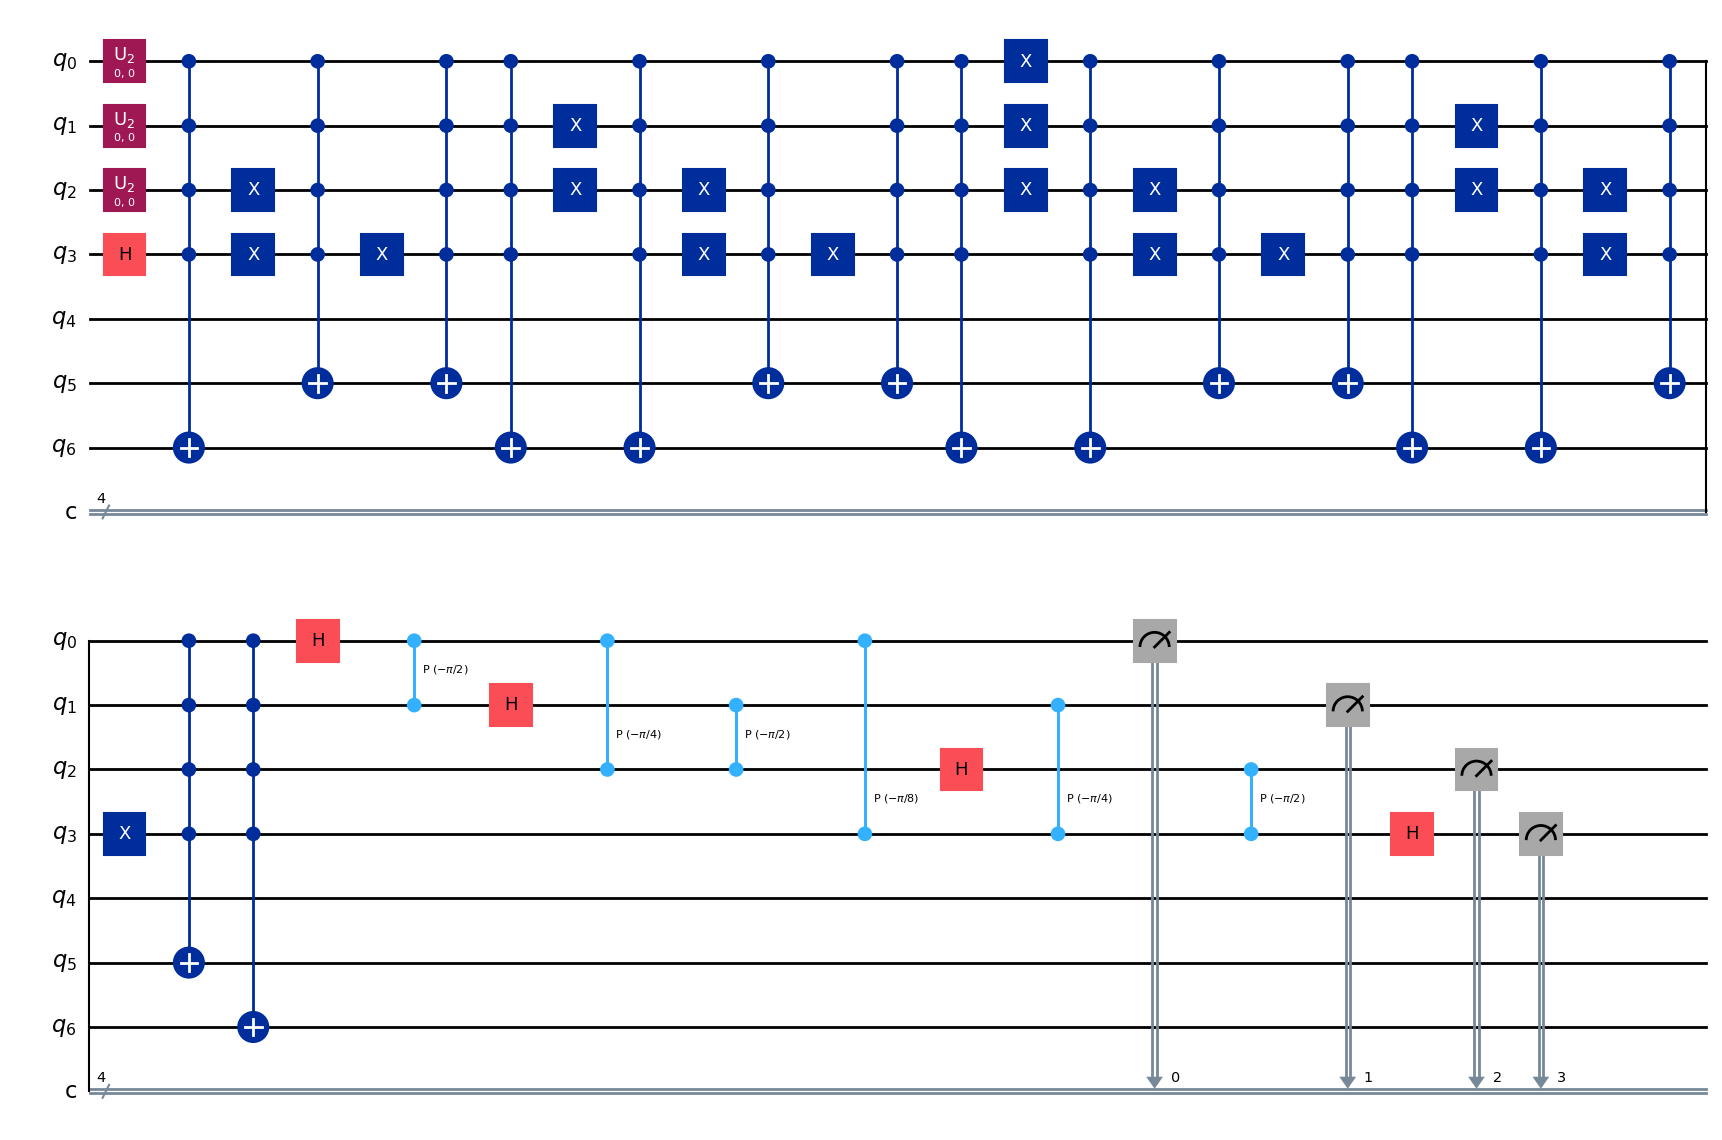

In [ ]:
  qc.draw("mpl")